# Usage example of hrf_estimation


Here we will use real fMRI data to estimate the HRF and activation pattern using the python package <code><a href="pypi.python.org/pypi/hrf_estimation">hrf_estimation</a></code>.




### Establish environment

In [1]:
# import packages we will need
%pylab inline

# nicer plots, but only available in recent matplotlib
try:
    plt.style.use('ggplot')
except:
    pass

import hrf_estimation as he
print('You are running hrf_estimation version %s' % he.__version__)
import pandas as pd
import numpy as np
import nibabel as nib

Populating the interactive namespace from numpy and matplotlib
You are running hrf_estimation version 1.0


###Load 7T data
We'll be using the 7T data from Nov. 2011

NOTE: You will want to import your pre-processing database and use it to locate/dowload corresponding pre-processed volumes. You should use the latest version of both. Here I am using an old version of the db/volumes. The db points to a drive on ichi so I have to correct for this when I read data in.

In [2]:
##load .csv database into a pandas dataframe
db_field_names = ['date',
'subject',
'expID',
'working_vol',
'brain_mask',
'sessionID',
'runType',
'designMatrixName',
'frameFileName',
'runName',
'nVols',
'tesla',
'magnetSite',
'runPath',
'tr',
'matrixSizeX',
'matrixSizeY',
'matrixSizeZ',
'voxResX',
'voxResY',
'voxResZ',
'runCodePath',
'runCodeName',
'designMatrixPath',
'frameFilePath',
'picPath',
'seimensRef',
'padVol']

data_db = pd.io.parsers.read_csv('/musc.repo/mri/7T.cmrr/databases/7Texp.csv',names=db_field_names)

In [3]:
data_db.head()

,date,subject,expID,working_vol,brain_mask,sessionID,runType,designMatrixName,frameFileName,runName,...,voxResX,voxResY,voxResZ,runCodePath,runCodeName,designMatrixPath,frameFilePath,picPath,seimensRef,padVol
0,6/30/2011,KH,lotusHill.7T.em6K.hires,/Data/7T.cmrr/workingvols/KHlotusHill.7T.em6K....,/Data/7T.cmrr/workingvols/KHlotusHill.7T.em6K....,1,trn,onoffTrn.mat,trn001.txt,MR-SE004-eja_ep2d_bold_1mm_1500TR,...,1,1,2,/Data/7T.cmrr/Presentation/buffermovie02082010,June20117T.py,/Data/7T.cmrr/Presentation/June2011,/Data/7T.cmrr/Presentation/June2011,/Data/7T.cmrr/Presentation/pictures,1,1
1,6/30/2011,KH,lotusHill.7T.em6K.hires,/Data/7T.cmrr/workingvols/KHlotusHill.7T.em6K....,/Data/7T.cmrr/workingvols/KHlotusHill.7T.em6K....,1,trn,onoffTrn.mat,trn002.txt,MR-SE005-eja_ep2d_bold_1mm_1500TR,...,1,1,2,/Data/7T.cmrr/Presentation/buffermovie02082010,June20117T.py,/Data/7T.cmrr/Presentation/June2011,/Data/7T.cmrr/Presentation/June2011,/Data/7T.cmrr/Presentation/pictures,1,1
2,6/30/2011,KH,lotusHill.7T.em6K.hires,/Data/7T.cmrr/workingvols/KHlotusHill.7T.em6K....,/Data/7T.cmrr/workingvols/KHlotusHill.7T.em6K....,1,trn,onoffTrn.mat,trn003.txt,MR-SE006-eja_ep2d_bold_1mm_1500TR,...,1,1,2,/Data/7T.cmrr/Presentation/buffermovie02082010,June20117T.py,/Data/7T.cmrr/Presentation/June2011,/Data/7T.cmrr/Presentation/June2011,/Data/7T.cmrr/Presentation/pictures,1,0
3,6/30/2011,KH,lotusHill.7T.em6K.hires,/Data/7T.cmrr/workingvols/KHlotusHill.7T.em6K....,/Data/7T.cmrr/workingvols/KHlotusHill.7T.em6K....,1,trn,onoffTrn.mat,trn004.txt,MR-SE014-eja_ep2d_bold_1mm_1500TR,...,1,1,2,/Data/7T.cmrr/Presentation/buffermovie02082010,June20117T.py,/Data/7T.cmrr/Presentation/June2011,/Data/7T.cmrr/Presentation/June2011,/Data/7T.cmrr/Presentation/pictures,1,0
4,6/30/2011,KH,lotusHill.7T.em6K.hires,/Data/7T.cmrr/workingvols/KHlotusHill.7T.em6K....,/Data/7T.cmrr/workingvols/KHlotusHill.7T.em6K....,1,val,onoffVal.mat,val001.txt,MR-SE007-eja_ep2d_bold_1mm_1500TR,...,1,1,2,/Data/7T.cmrr/Presentation/buffermovie02082010,June20117T.py,/Data/7T.cmrr/Presentation/June2011,/Data/7T.cmrr/Presentation/June2011,/Data/7T.cmrr/Presentation/pictures,1,0


#### We want lotusHill.7T.em9K.1.5iso experiment

In [4]:
np.unique(data_db['expID'])
##and we will only keep the columns we need
lotushill_data = data_db[data_db['expID']=='lotusHill.7T.em9K.1.5iso'][['subject', 'runType', 'tr', 'matrixSizeX',
                                                                        'matrixSizeY', 'matrixSizeZ', 'nVols','frameFilePath',
                                                                        'frameFileName', 'working_vol']]
lotushill_data.head()

,subject,runType,tr,matrixSizeX,matrixSizeY,matrixSizeZ,nVols,frameFilePath,frameFileName,working_vol
136,DM,trn,2,112,112,41,288,/Data/7T.cmrr/Presentation/Sept2011,trn001.txt,/Data/7T.cmrr/workingvols/DMlotusHill.7T.em9K....
137,DM,trn,2,112,112,41,288,/Data/7T.cmrr/Presentation/Sept2011,trn002.txt,/Data/7T.cmrr/workingvols/DMlotusHill.7T.em9K....
138,DM,trn,2,112,112,41,288,/Data/7T.cmrr/Presentation/Sept2011,trn002.txt,/Data/7T.cmrr/workingvols/DMlotusHill.7T.em9K....
139,DM,imgVal,2,112,112,41,136,/Data/7T.cmrr/Presentation/Sept2011,imgVal.txt,/Data/7T.cmrr/workingvols/DMlotusHill.7T.em9K....
140,DM,img,2,112,112,41,136,/Data/7T.cmrr/Presentation/Sept2011,img.txt,/Data/7T.cmrr/workingvols/DMlotusHill.7T.em9K....


As you can see above, there are three types of runs:
* "trn" = training runs, a stream of randomly selected photographs
* "imgVal" = imagery validation, 5 works of art preceded by a 3-letter cue
* "img" = imagery, here the subjects imagined the 5 works of art in response to the 3-letter cue

For details see methods section of:

Naselaris, Thomas, Cheryl A. Olman, Dustin E. Stansbury, Kamil Ugurbil, and Jack L. Gallant. “A Voxel-Wise Encoding Model for Early Visual Areas Decodes Mental Images of Remembered Scenes.” NeuroImage 105 (January 15, 2015): 215–28. http://www.sciencedirect.com/science/article/pii/S1053811914008428


####  Let's pre-process all of the validation data for one subject

In [5]:

subject = 'TN'
runType = 'imgVal'
cur_vols = lotushill_data[(lotushill_data['subject']==subject) & (lotushill_data['runType']==runType)]
cur_vols 

,subject,runType,tr,matrixSizeX,matrixSizeY,matrixSizeZ,nVols,frameFilePath,frameFileName,working_vol
163,TN,imgVal,2,108,108,39,236,/Data/7T.cmrr/Presentation/Nov2011,imgVal.txt,/Data/7T.cmrr/workingvols/TNlotusHill.7T.em9K....
186,TN,imgVal,2,108,108,39,236,/Data/7T.cmrr/Presentation/Nov2011,imgVal.txt,/Data/7T.cmrr/workingvols/TNlotusHill.7T.em9K....
205,TN,imgVal,2,108,108,39,236,/Data/7T.cmrr/Presentation/Nov2011,imgVal.txt,/Data/7T.cmrr/workingvols/TNlotusHill.7T.em9K....


#### Here we build a few functions for reading/parsing the relevant data
NOTE: THESE ARE COMPLETELY NON-GENERAL, SPECIFIC TO THIS EXPERIMENT ONLY

##### where all the happens to be stored on my local machine. Because the database I'm using here is old, we have to replace some strings

In [6]:
data_root = '/media/tnaselar/Data/lotushill_7T_data/'

##### a function for loading in volumes from the database

In [7]:

def load_data(df_row):
    return nib.load(df_row['working_vol'].replace('/Data/7T.cmrr/workingvols/', data_root))  ##<<note change of data location! You won't need to do this



(108, 108, 39, 236)


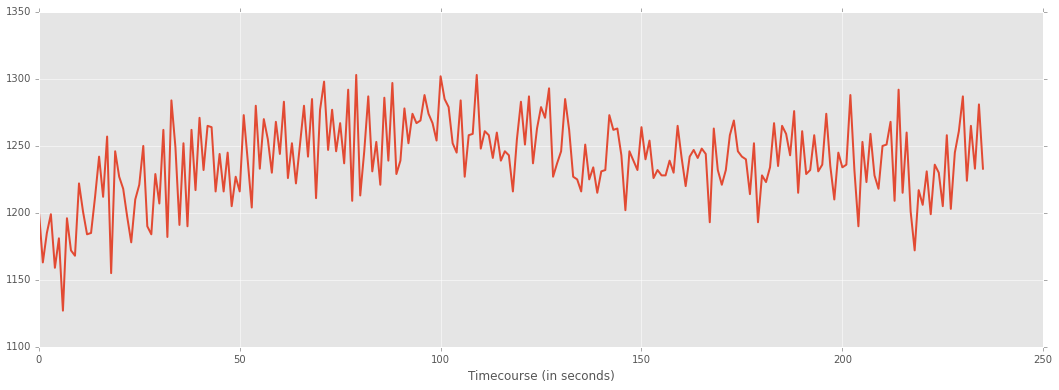

In [8]:
##exercise!
which_run = 0
which_voxel = (50,50,18)
one_vol = load_data(cur_vols.iloc[which_run])
print one_vol.get_data().shape
time_course = one_vol.get_data()[which_voxel[0], which_voxel[1], which_voxel[2], :]
plt.figure(figsize=(18, 6))
plt.plot(time_course, lw=2)
plt.xlabel('Timecourse (in seconds)')

Note the obvious low-frequency trend

##### functions for loading the sequence of conditions

In [9]:
def image_id(string_list):
    try:
        digits = map(lambda x: int(x.replace('.png', '')), string_list)
    except:
        1/0
    big = np.argmax(digits)
    return digits[big], string_list[big]


def load_frame_file(df_row):    
    cond_file = df_row['frameFilePath'].replace('/Data/7T.cmrr/Presentation/Nov2011', data_root+'framefiles/')+df_row['frameFileName']
    with open(cond_file, 'r') as content_file:
        cond_list = content_file.read()
    cond_list = cond_list.strip().split('\n')
    return cond_list

##returns 
def load_conditions(df_row):
  
    chunksize = 10  ##each chunk should span 1 TR
    TR = df_row['tr']
    cond_list = load_frame_file(df_row)
    condition_map = dict() ## a map from image_ids to a condition number
    condition_number = 0   ##this will determine the design matrix column for each image
    condition_sequence = [] ##the sequence in which images were shown
    condition_onsets = []  ##the times (in seconds) when images were shown
    for TR_counter, chunk in enumerate(range(0,len(cond_list), chunksize)):
        one_tr = cond_list[chunk:chunk+chunksize]
        stim_digit, stim_string = image_id(one_tr) ##<<grab the image id
        if stim_digit > 0:
            if stim_string not in condition_map.keys():
                condition_map[stim_string] = condition_number
                condition_number += 1
            condition_sequence.append(condition_map[stim_string])
            condition_onsets.append(TR_counter*TR)
    return condition_map, condition_sequence, condition_onsets

        

In [10]:
##exercise!
cond_info = load_conditions(cur_vols.iloc[0])
print cond_info[0] ##get the conditions map
print cond_info[1][0:10]  ##get first 10 images in conditions sequence
print cond_info[2][0:10]  ##get corresponding onset times in units of TR

{'004247.png': 3, '004246.png': 2, '004245.png': 0, '004244.png': 4, '004243.png': 1}
[0, 1, 0, 1, 2, 3, 1, 4, 3, 4]
[24.0, 30.0, 36.0, 42.0, 48.0, 54.0, 66.0, 72.0, 78.0, 90.0]


##### Add new columns to df containing the functional volumes and the stimulus information

In [12]:
##append the volumes as a new column in the df
cur_vols['volume_data'] = cur_vols.apply(lambda row: load_data(row), axis=1)

##append condition information as a new column in the df
cur_vols['condition_info'] = cur_vols.apply(lambda row: load_conditions(row), axis=1)


In [13]:
cur_vols.head()

,subject,runType,tr,matrixSizeX,matrixSizeY,matrixSizeZ,nVols,frameFilePath,frameFileName,working_vol,volume_data,condition_info
163,TN,imgVal,2,108,108,39,236,/Data/7T.cmrr/Presentation/Nov2011,imgVal.txt,/Data/7T.cmrr/workingvols/TNlotusHill.7T.em9K....,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"({u'004247.png': 3, u'004246.png': 2, u'004245..."
186,TN,imgVal,2,108,108,39,236,/Data/7T.cmrr/Presentation/Nov2011,imgVal.txt,/Data/7T.cmrr/workingvols/TNlotusHill.7T.em9K....,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"({u'004247.png': 3, u'004246.png': 2, u'004245..."
205,TN,imgVal,2,108,108,39,236,/Data/7T.cmrr/Presentation/Nov2011,imgVal.txt,/Data/7T.cmrr/workingvols/TNlotusHill.7T.em9K....,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"({u'004247.png': 3, u'004246.png': 2, u'004245..."


##### Look at a design matrix -- test the f#!k out of it to make sure it's right!!

(236, 15)


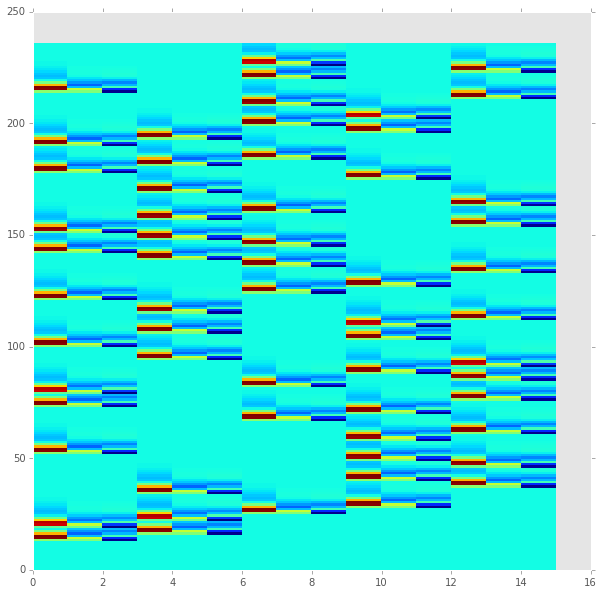

In [15]:
which_run = 0
cond_seq = cur_vols['condition_info'].iloc[which_run][1]
cond_ons = cur_vols['condition_info'].iloc[which_run][2]
n_scans = cur_vols['nVols'].iloc[which_run]
TR = cur_vols['tr'].iloc[which_run]
# print cond_seq
# print cond_ons
des_mat, basis = he.create_design_matrix(cond_seq,cond_ons,TR = float(TR),n_scans=n_scans, basis = '3hrf')
print des_mat.shape
plt.figure(figsize=(10,10))
plt.pcolor(des_mat)

Note the number of columns. It is the number of conditions x the number of basis functions. These basis functions are 
used to construct the HRF.

###Detrend the functional data

###### Now the data is stored we can do something to it. In the next step we will detrend the signal using a Savitzky-Golay filter with polynomial of degree three and window length of [?] seconds. The time series for one voxel is plotted after detrending.

##### detrend the random voxel we looked at earlier

Performed detrending of the BOLD timecourse using a Savitzky-Golay filter


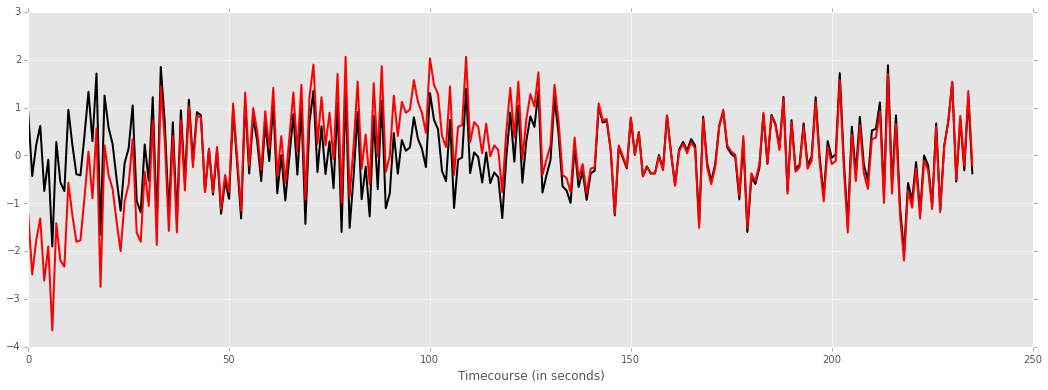

In [15]:
### perform detrending: Savitzky-Golay filter
window_length = 91 ##<<play with this. 
poly_order = 3 ##<<mess with this too
detrended_time_course = time_course - he.savitzky_golay.savgol_filter(time_course, window_length, poly_order, axis=0)
detrended_time_course /= time_course.std(axis=0)
print("Performed detrending of the BOLD timecourse using a Savitzky-Golay filter")

# plot detrended time course
plt.figure(figsize=(18, 6))
plt.plot(detrended_time_course, 'k', lw=2)

#compare to z-scored but un-de-trended timecourse
zt = time_course-time_course.mean(axis=0)
zt /= zt.std()
plt.plot(zt, 'r', lw=2)
plt.xlabel('Timecourse (in seconds)')


### HRF estimation

We will proceed to estimate the HRF using a R1GLM model.

We will now call the <code>glm</code> function in <code>hrf_estimation</code>. We will use a basis formed by the HRF plus its time and dispersion derivatives. This basis is denoted '3hrf' in this package.

NOTE: This is all applied to un-detrended data!! Make sure  to apply it to detrended data!!!

##### looks like the glm code wants data in a time x voxels matrix.

In [20]:
##load a volume and reformat it into a voxels x time matrix -- check to make sure this is working!!
which_run = 0
voxels = load_data(cur_vols.iloc[which_run])
n_voxels = np.prod(voxels.shape[0:3])
n_scans = cur_vols['nVols'].iloc[which_run]
TR = cur_vols['tr'].iloc[which_run]
print n_voxels
print n_scans
voxels = voxels.get_data().reshape((n_voxels,n_scans))
print voxels.shape

454896
236.0
(454896, 236)


In [24]:
##load the conditions information
cond_seq = cur_vols['condition_info'].iloc[which_run][1]
cond_ons = cur_vols['condition_info'].iloc[which_run][2]

In [34]:
# we construct the matrix of drifts as the matrix of ones that account for
# the intercept term. If you have drifts estimated by e.g. SPM you can add
# them here.
drifts = np.ones((voxels.T.shape[0], 1))

##fit this! 
hrfs, betas = he.glm(cond_seq, cond_ons, TR, voxels.T, drifts=drifts, mode='r1glm', basis='3hrf', verbose=1)

For ~500K voxels and one run, this took less than an hour on a single computer. I belive the he.glm function can be multithreaded, so try that.

In [27]:
print betas.shape
print hrfs.shape

(5, 454896)
(3, 454896)


In [ ]:
xx = np.linspace(0, 25) # range of values for time
# construct the final HRF by multiplying by its basis
generated_hrfs = hrfs[0] * he.hrf.spmt(xx)[:, None] + hrfs[1] * he.hrf.dspmt(xx)[:, None] + hrfs[2] * he.hrf.ddspmt(xx)[:, None]

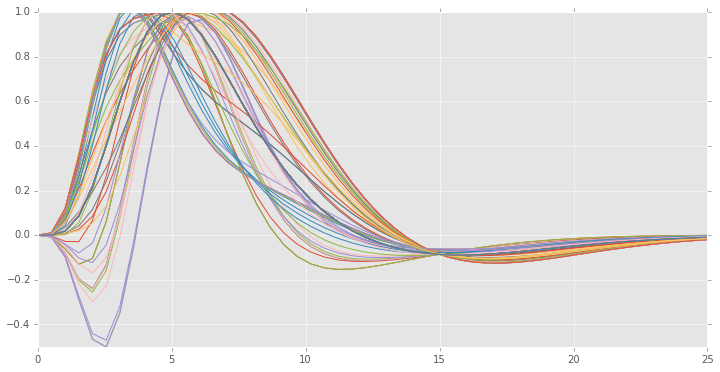

In [31]:
random_voxels = np.random.randint(0,high=n_voxels,size=100)
plt.figure(figsize=(12, 6))
plt.plot(xx, generated_hrfs[:,random_voxels])
plt.ylim((-.5, 1.))
plt.show()

We shouldn't get too excited by the fact that we nice-looking HRFs. Because we used the "3hrf" basis, we are guaranteed to get smooth-looking HRFs. So now let's run it with a basis that is completely flexible, and will give us any shape whatever. How do our HRF's look then?

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   6.00000000e+00,
          3.00000000e+00,   5.00000000e+00,   2.00000000e+00,
          1.10000000e+01,   7.00000000e+00,   1.20000000e+01,
          1.80000000e+01,   1.50000000e+01,   2.00000000e+01,
          2.20000000e+01,   3.90000000e+01,   3.30000000e+01,
          3.80000000e+01,   5.80000000e+01,   7.40000000e+01,
          9.90000000e+01,   1.22000000e+02,   1.63000000e+02,
          2.05000000e+02,   3.00000000e+02,   3.90000000e+02,
          5.37000000e+02,   7.35000000e+02,   1.06400000e+03,
          1.58700000e+03,   2.38800000e+03,   3.62500000e+03,
          5.82400000e+03,   9.91600000e+03,   1.80000000e+04,
          3.36710000e+04,   6.37400000e+04,   1.07135000e+05,
        

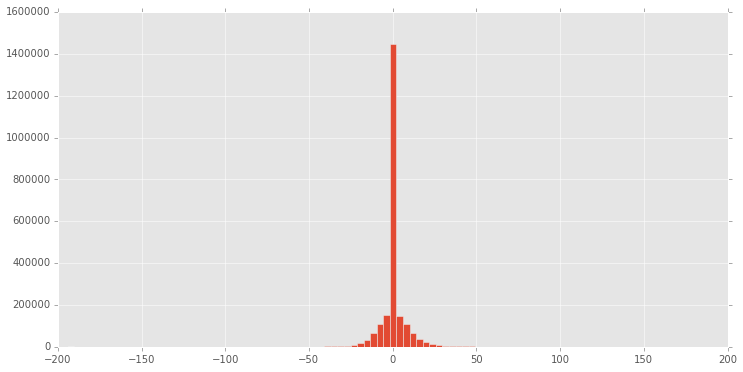

In [32]:
plt.figure(figsize=(12, 6))
plt.hist(betas.ravel(),bins=100)

We can also fit the HRFs with an "fir" basis. In this case, the basis function are just timepoints, and we fit a separate
HRF for each voxel and each condition. In this case, the shape of the HRF is completely determined by the data.

In [35]:
flexi_hrfs, flexi_betas = he.glm(cond_seq, cond_ons, TR, voxels.T, drifts=drifts, mode='r1glm', basis='fir', verbose=1)

This approach takes much longer because there will be many more parameters to fit. Be careful with this!

The measurements here are quite noisy. This is somewhat expected because the FIR basis has many more parameters to estimate than the 3hrf basis and the model is learning noise given the limited time points. This phenomenon is known as _overfitting_ in machine learning. One possible solution is to incorporate more data into the model. We can do this for example by accumulating the data from the different sessions into a big R1-GLM. 

In this case we would create a desig matrix in which the diagonal blocks are the design matrices for each of the respective session. This way the HRF will be constrained to be common across the different sessions but we will still have the same number of activation coefficients (beta-map) as if we performed the model for each session individually. The target variable (voxel timecourse) in this model will be simply the concatenation of the timecourse for the considered sessions.

#### Combining multiple runs -- this is an exercise for you
Below is the way they did it for a different data set. Adapt this approach to our dataset.

In [23]:
design_all_sessions = []
voxels_all_sessions = []
drifts_all_sessions = []
n_basis = 20
for sess in range(5):
    voxels, conditions, onsets = he.data.get_sample_data(sess, full_brain=False)

    # detrending
    n_voxels = voxels.shape[-1]
    voxels = voxels - he.savitzky_golay.savgol_filter(voxels, 91, 3, axis=0)
    voxels /= voxels.std(axis=0)
    voxels_all_sessions.append(voxels)

    # create design matrix
    design, _ = he.utils.create_design_matrix(conditions, onsets, 1., voxels.shape[0], hrf_length=n_basis, basis='fir')
    design_all_sessions.append(design)
    drifts_all_sessions.append(np.ones((voxels.shape[0], 1)))

In [126]:
len(np.unique(conditions))

350

In [24]:
from scipy import sparse
design = sparse.block_diag(design_all_sessions)
drifts = sparse.block_diag(drifts_all_sessions)
out = he.rank_one(design, np.reshape(voxels_all_sessions, (-1, 500)), n_basis, drifts=drifts)

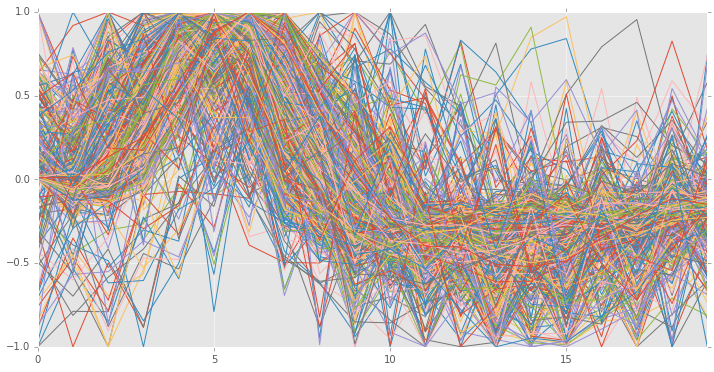

In [30]:
# plot the result
hrfs, beta = out
sign = np.sign(np.dot(hrfs.T, he.hrf.spmt(np.arange(n_basis))))
plt.figure(figsize=(12, 6))
plt.plot(np.arange(hrfs.shape[0]), (sign * hrfs) / np.abs(hrfs).max(0))
#plt.ylim((-.5, 1.))
plt.axis('tight')
plt.show()

This estimation is ness noisy. In the original dataset there are two more sessions (used for validation) that can also be used for the estimation. 

### TODO: Visualizing the results in functional (volume) space